In [1]:
!pip install pandas
!pip install numpy
!pip install torchvision
!pip install scikit-learn
!pip install tensorflow
!pip install seaborn
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 22.8 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 73.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.0/865.0 MB 22.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 44.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 31.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 23.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 29.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 58.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

2025-05-28 11:29:50.110775: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 11:29:50.119053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748431790.128722     133 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748431790.131615     133 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748431790.140005     133 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [5]:
df_traindata = pd.read_csv("../data/train.csv")

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df_traindata['sentiment'].tolist())

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_traindata['text'].tolist())
sequences = tokenizer.texts_to_sequences(df_traindata['text'].tolist())
padded_sequences = pad_sequences(sequences, maxlen=15, padding='post', truncating='post')

train_texts, validation_texts, train_labels, validation_labels = train_test_split(
    padded_sequences.tolist(), 
    labels.tolist(), 
    test_size=0.2, 
    random_state=42
)
train_texts = np.array(train_texts)
train_labels = np.array(train_labels)
validation_texts = np.array(validation_texts)
validation_labels = np.array(validation_labels)

df_testdata = pd.read_csv("../data/test.csv")
label_encoder = LabelEncoder()
labels_test = label_encoder.fit_transform(df_testdata['sentiment'].tolist())

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_testdata['text'].tolist())
sequences = tokenizer.texts_to_sequences(df_testdata['text'].tolist())
padded_sequences_test = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')


In [8]:
wandb.login(key=os.getenv('WANDB_KEY'))
wandb.init(project="nlp-lantsch-schmassmann-wigger", entity="nlp-lantsch-schmassmann-wigger")

model = Sequential([
    Embedding(input_dim=10000, output_dim=64),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

class WandbCallback(wandb.keras.WandbCallback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log({
            "epoch_loss": logs["loss"],
            "epoch_accuracy": logs["accuracy"],
            "val_loss": logs["val_loss"],
            "val_accuracy": logs["val_accuracy"]
        })
        super().on_epoch_end(epoch, logs)

history = model.fit(
    train_texts,
    train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(validation_texts, validation_labels),
    callbacks=[WandbCallback(save_graph=False, save_model=False)]
)

wandb.finish()

Epoch 1/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.7287 - loss: 0.5344 - val_accuracy: 0.7736 - val_loss: 0.4890
Epoch 2/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 34s 8ms/step - accuracy: 0.7946 - loss: 0.4398 - val_accuracy: 0.7787 - val_loss: 0.4655
Epoch 3/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.8124 - loss: 0.4055 - val_accuracy: 0.7780 - val_loss: 0.4673
Epoch 4/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.8325 - loss: 0.3705 - val_accuracy: 0.7739 - val_loss: 0.4761
Epoch 5/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.8497 - loss: 0.3388 - val_accuracy: 0.7697 - val_loss: 0.5014
Epoch 6/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.8625 - loss: 0.3098 - val_accuracy: 0.7672 - val_loss: 0.5524
Epoch 7/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.8749 - loss: 0.2828 - val_accuracy: 0.7591 - val_loss: 0.6335
Epoch 8/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.8876 - loss: 0

accuracy,▁▁▃▄▄▅▆▆▇██
epoch,▁▁▂▃▃▄▅▆▆▇█
epoch_accuracy,▁▁▃▄▄▅▆▆▇██
epoch_loss,██▇▆▅▄▃▃▂▂▁
loss,██▇▆▅▄▃▃▂▂▁
val_accuracy,██▇▇████▇▇▅▅▅▅▃▃▃▃▁▁▁▁
val_loss,▁▁▂▂▁▁▁▁▁▁▂▂▃▃▄▄▆▆██▇▇
accuracy,0.90318
best_epoch,0
best_val_loss,0.46081
epoch,9


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5482 - loss: 1.3343
Test Accuracy: 0.55
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
              precision    recall  f1-score   support

    negative       0.71      0.69      0.70     15109
    positive       0.78      0.80      0.79     20890

    accuracy                           0.75     35999
   macro avg       0.75      0.75      0.75     35999
weighted avg       0.75      0.75      0.75     35999



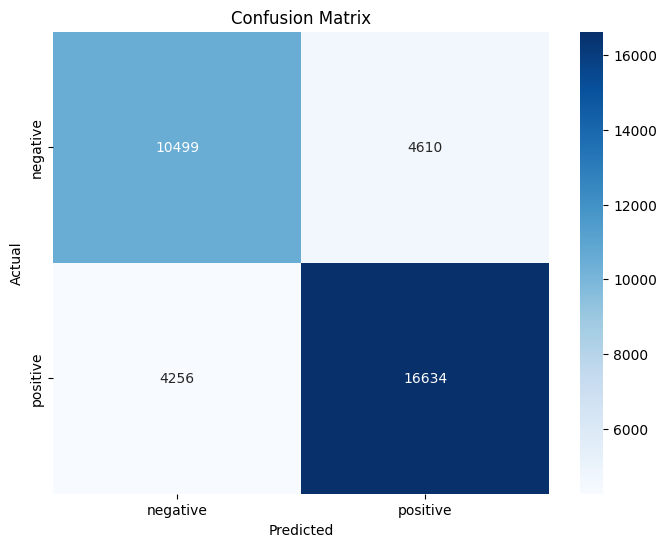

In [9]:
loss, accuracy = model.evaluate(padded_sequences_test, labels_test)
print(f"Test Accuracy: {accuracy:.2f}")

y_pred = (model.predict(validation_texts) > 0.5).astype("int32")

print(classification_report(validation_labels, y_pred, target_names=['negative', 'positive']))

cm = confusion_matrix(validation_labels, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [11]:
wandb.login(key=os.getenv('WANDB_KEY'))
wandb.init(project="nlp-lantsch-schmassmann-wigger", entity="nlp-lantsch-schmassmann-wigger")

model = Sequential([
    Embedding(input_dim=10000, output_dim=64),
    LSTM(32, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

class WandbCallback(wandb.keras.WandbCallback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log({
            "epoch_loss": logs["loss"],
            "epoch_accuracy": logs["accuracy"],
            "val_loss": logs["val_loss"],
            "val_accuracy": logs["val_accuracy"]
        })
        super().on_epoch_end(epoch, logs)

history = model.fit(
    train_texts,
    train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(validation_texts, validation_labels),
    callbacks=[WandbCallback(save_graph=False, save_model=False)]
)

wandb.finish()

Epoch 1/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.7231 - loss: 0.5425 - val_accuracy: 0.7747 - val_loss: 0.4639
Epoch 2/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.7945 - loss: 0.4433 - val_accuracy: 0.7786 - val_loss: 0.4587
Epoch 3/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.8132 - loss: 0.4120 - val_accuracy: 0.7763 - val_loss: 0.4620
Epoch 4/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.8305 - loss: 0.3792 - val_accuracy: 0.7772 - val_loss: 0.4890
Epoch 5/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - accuracy: 0.8474 - loss: 0.3463 - val_accuracy: 0.7715 - val_loss: 0.5091
Epoch 6/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.8611 - loss: 0.3174 - val_accuracy: 0.7656 - val_loss: 0.5629
Epoch 7/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.8753 - loss: 0.2884 - val_accuracy: 0.7607 - val_loss: 0.5743
Epoch 8/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.8855 - loss: 0

accuracy,▁▃▄▅▅▆▆▇██
epoch,▁▂▃▃▄▅▆▆▇█
epoch_accuracy,▁▃▄▅▅▆▆▇██
epoch_loss,█▆▆▅▄▃▃▂▂▁
loss,█▆▆▅▄▃▃▂▂▁
val_accuracy,▇▇██▇▇██▆▆▄▄▃▃▂▂▂▂▁▁
val_loss,▁▁▁▁▁▁▂▂▂▂▃▃▄▄▅▅▇▇██
accuracy,0.89905
best_epoch,1
best_val_loss,0.45874
epoch,9


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5762 - loss: 1.2924
Test Accuracy: 0.57
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

    negative       0.73      0.67      0.70     15109
    positive       0.77      0.82      0.79     20890

    accuracy                           0.75     35999
   macro avg       0.75      0.74      0.74     35999
weighted avg       0.75      0.75      0.75     35999



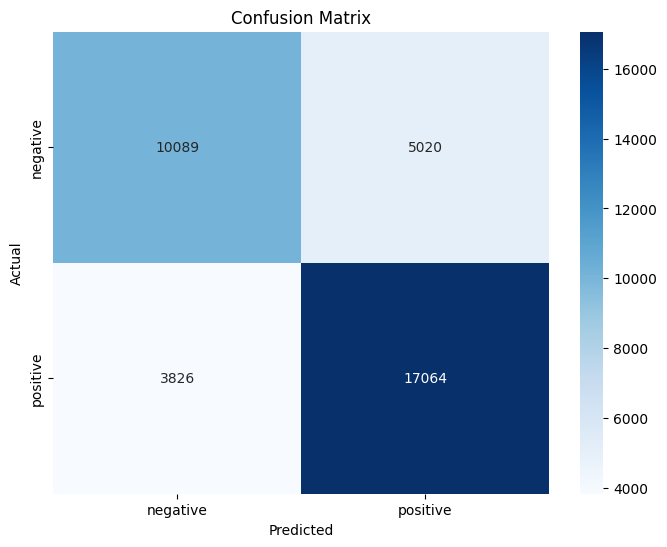

In [12]:
loss, accuracy = model.evaluate(padded_sequences_test, labels_test)
print(f"Test Accuracy: {accuracy:.2f}")

y_pred = (model.predict(validation_texts) > 0.5).astype("int32")

print(classification_report(validation_labels, y_pred, target_names=['negative', 'positive']))

cm = confusion_matrix(validation_labels, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()